In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
import seaborn as sns

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
%matplotlib inline 

In [4]:
ames = pd.read_csv('./data/Ames_Housing_Price_Data.csv')
ames = ames.iloc[:,1:]

## Feature type check

In [5]:
ames.columns = ames.columns.str.lower()
ames.mssubclass = ames.mssubclass.astype('object')
ames.mosold = ames.mosold.astype('object')

By readling the data dictionaory, a few features come in ordinary scale, such as 'OverallQual' and 'OverallCond'. To decide whether or not to convert these data type, we check the scatter plot of saleprice against these features, to see if there is a linear pattern.

In [6]:
oridinal_col = ['overallqual','overallcond','exterqual','extercond','bsmtqual','bsmtcond','bsmtfintype1',\
                'bsmtfintype2','kitchenqual','fireplacequ','poolqc','garagecond','garagequal']

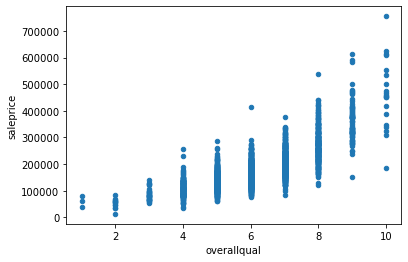

In [7]:
ames[['overallqual','saleprice']].plot(x='overallqual',y='saleprice',kind='scatter')

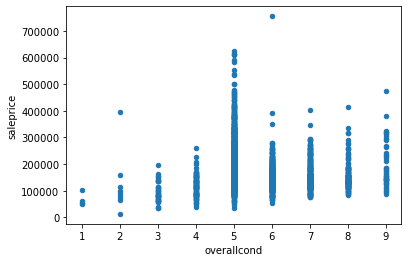

In [8]:
ames[['overallcond','saleprice']].plot(x='overallcond',y='saleprice',kind='scatter')

'overallqual' and 'overallcond' show nearly linear pattern, therefore these 2 columns will be treated as numeric values in the data set. All others will be treated as categorial features.

## Missing Data Cleanning

Missingness: it seems that all the missing come from a non-existing feature, therefore I fill in all the numeric features with 0 and categorical features with ‘No [feature]’ or similar pattern. 

### Remarks:

*mansvnrtype / masvnrarea: missing because the house is solid brick? In that case, the price might be different.

*garage: row 433, 531 have garage type but with many missing values in garage specs

*‘Electrical’ : 1 missing data

*When 'Garagetype' is ‘no garage’, the value of 'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal', 'garagecond' will have multicollinearity since they will all be coded 0 or ‘No Garage’. For ML purposes, the overall model will include ‘garagetype’ or 'garagearea' only, if significant, the data set will be split in with/without garage for further analysis.

*The same with the basement features group.

In [9]:
ames.loc[ames.lotfrontage.isnull(),'lotfrontage'] = 0
ames.loc[ames.alley.isnull(),'alley'] = 'No Alley'
ames.loc[ames.masvnrtype.isnull(),'masvnrtype'] = 'Missing'
ames.loc[ames.masvnrarea.isnull(),'masvnrarea'] = 0
ames.loc[ames.bsmtqual.isnull(),'bsmtqual'] = 'No Bsmt'
ames.loc[ames.bsmtcond.isnull(),'bsmtcond'] = 'No Bsmt'
ames.loc[ames.bsmtexposure.isnull(),'bsmtexposure'] = 'No Bsmt'
ames.loc[ames.bsmtfintype1.isnull(),'bsmtfintype1'] = 'No Bsmt'
ames.loc[ames.bsmtfinsf1.isnull(),'bsmtfinsf1'] = 0
ames.loc[ames.bsmtfintype2.isnull(),'bsmtfintype2'] = 'No Bsmt'
ames.loc[ames.bsmtfinsf2.isnull(),'bsmtfinsf2'] = 0
ames.loc[ames.bsmtunfsf.isnull(),'bsmtunfsf'] = 0
ames.loc[ames.totalbsmtsf.isnull(),'totalbsmtsf'] = 0
ames.loc[ames.bsmtfullbath.isnull(),'bsmtfullbath'] = 0
ames.loc[ames.bsmthalfbath.isnull(),'bsmthalfbath'] = 0
ames.loc[ames.fireplaces == 0,'fireplacequ'] = 'No Fireplace'
ames.loc[ames.garagetype.isnull(),'garagetype'] = 'No Garage'
ames.loc[ames.garagetype == 'No Garage','garageyrblt'] = 0
ames.loc[ames.garagetype == 'No Garage','garagefinish'] = 'No Garage'
ames.loc[ames.garagetype == 'No Garage','garagecars'] = 0
ames.loc[ames.garagetype == 'No Garage','garagearea'] = 0
ames.loc[ames.garagetype == 'No Garage','garagequal'] = 'No Garage'
ames.loc[ames.garagetype == 'No Garage','garagecond'] = 'No Garage'
ames.loc[ames.poolarea == 0,'poolqc'] = 'No Pool'
ames.loc[ames.fence.isnull(),'fence'] = 'No Fence'
ames.loc[ames.miscfeature.isnull(),'miscfeature'] = 'None'

In [10]:
ames.loc[ames.garageyrblt.isnull(),]

,pid,grlivarea,saleprice,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition
433,910201180,1828,150909,70,RM,50.0,9060,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,0.0,0.0,2,0,3,1,Gd,6,Typ,0,No Fireplace,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,No Pool,MnPrv,None,0,3,2007,WD,Alloca
531,903426160,1984,160000,60,RM,57.0,8094,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,8,1910,1983,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,196.0,Unf,0.0,1046.0,1242.0,GasA,Gd,Y,SBrkr,1242,742,0,0.0,0.0,2,0,5,1,TA,8,Typ,0,No Fireplace,Detchd,NaN,NaN,1.0,360.0,NaN,NaN,Y,64,0,180,0,0,0,No Pool,MnPrv,Shed,1000,9,2008,WD,Normal


In [11]:
ames.loc[ames.electrical.isnull(),]

,pid,grlivarea,saleprice,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition
2442,916386080,1394,167500,80,RL,73.0,9735,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,NaN,754,640,0,0.0,0.0,2,1,3,1,Gd,7,Typ,0,No Fireplace,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,No Pool,No Fence,None,0,5,2008,WD,Normal


After the major data cleaning, 3 rows are still left with missing values. After checking the 3 records, the missing information cannot be imputed easily with existing information, so we decide to remove these 3 rows. 2577 rows of data will be included in the analysis.

In [12]:
ames2 = ames.dropna(axis=0).copy()
ames2.shape

(2577, 81)

## Adding Features

- 'price_sqft' = 'saleprice' / 'grlivarea'
 
- 'house_age'  = 'yrsold' - 'yearbuilt'
 
- 'reno_age' = 'yrsold' - 'yearremodadd'
 
- bathroom # above ground: 'tbath_abvgr' = 'fullbath' + 'halfbath'*0.5

- bathroom # in basement: 'tbath_bsmt' = 'bsmtfullbath' + 'bsmthalfbath'*0.5
 
- bedroom/bathroom ratio (above ground): 'bbratio_abvgr' = 'bedroomabvgr' / 'tbath_abvgr'
  
There are two houses only have bathroom in basement, so the 'bbratio_abvgr' will be uncalculatble. 

To make sense of the date, impute the missing data with 10.

### Be aware of multicollinearity between the introduced variables

In [13]:
ames2['price_sqft'] = ames2['saleprice'] / ames2['grlivarea']
ames2['house_age'] = ames2['yrsold'] - ames2['yearbuilt']
ames2['reno_age'] = ames2['yrsold'] - ames2['yearremodadd']
ames2.loc[ames2['reno_age']<0,'reno_age'] = 0
ames2['bbratio_abvgr'] = ames2['bedroomabvgr']/(ames2['fullbath'] + ames2['halfbath']*0.5 +\
                                                ames2['bsmtfullbath'] + ames2['bsmthalfbath']*0.5)
ames2.loc[ames2['bbratio_abvgr'].isnull(),'bbratio_abvgr'] = 10
ames2.loc[ames2['bbratio_abvgr']>10,'bbratio_abvgr'] = 10
ames2['tporch'] = ames2['wooddecksf']+ames2['openporchsf']+ames2['enclosedporch']\
                           +ames2['3ssnporch']+ames2['screenporch']

## Check Outliers

outliers: price higher or lower than 3 std

In [14]:
ames2[['saleprice','price_sqft']].describe()

,saleprice,price_sqft
count,2577.000000,2577.000000
mean,178081.264649,120.934759
std,75071.726566,30.637014
min,12789.000000,15.371394
25%,129900.000000,100.401606
50%,159900.000000,119.658120
75%,210000.000000,138.888889
max,755000.000000,276.250881


In [15]:
price_outliers = ames2[((ames2['saleprice'] - ames2['saleprice'].mean())/ames2['saleprice'].std() > 3) | \
     ((ames2['saleprice'] - ames2['saleprice'].mean())/ames2['saleprice'].std() < -3)]
outliersp = price_outliers.pid.tolist()
len(price_outliers)

42

In [16]:
price_outliers['saleprice'].mean()

479349.2380952381

The outliers in terms of saleprice are all high price houses. We will remove these houses to maintain the assumptions of regression model.

In [17]:
ames3 = ames2[~ames2['pid'].isin(price_outliers['pid'])]

(array([  4.,  19.,  92., 198., 481., 529., 367., 251., 196., 140.,  86.,
         55.,  50.,  29.,  25.,  15.,  13.,   7.,   8.,   2.,   0.,   3.,
          0.,   2.,   4.,   0.,   0.,   0.,   0.,   1.]),
 array([ 12789.        ,  37529.36666667,  62269.73333333,  87010.1       ,
        111750.46666667, 136490.83333333, 161231.2       , 185971.56666667,
        210711.93333333, 235452.3       , 260192.66666667, 284933.03333333,
        309673.4       , 334413.76666667, 359154.13333333, 383894.5       ,
        408634.86666667, 433375.23333333, 458115.6       , 482855.96666667,
        507596.33333333, 532336.7       , 557077.06666667, 581817.43333333,
        606557.8       , 631298.16666667, 656038.53333333, 680778.9       ,
        705519.26666667, 730259.63333333, 755000.        ]),
 <a list of 30 Patch objects>)

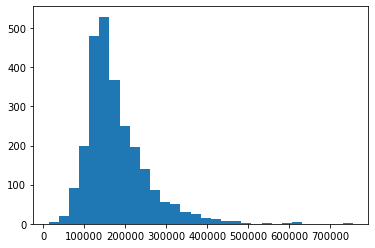

In [18]:
plt.hist(ames2['saleprice'], bins=30)

(array([  1.,   3.,   5.,  23.,  21.,  84.,  85., 158., 261., 308., 270.,
        204., 203., 177., 119., 113.,  86.,  80.,  63.,  56.,  49.,  27.,
         26.,  30.,  25.,  16.,   8.,  12.,  13.,   9.]),
 array([ 12789.        ,  25796.03333333,  38803.06666667,  51810.1       ,
         64817.13333333,  77824.16666667,  90831.2       , 103838.23333333,
        116845.26666667, 129852.3       , 142859.33333333, 155866.36666667,
        168873.4       , 181880.43333333, 194887.46666667, 207894.5       ,
        220901.53333333, 233908.56666667, 246915.6       , 259922.63333333,
        272929.66666667, 285936.7       , 298943.73333333, 311950.76666667,
        324957.8       , 337964.83333333, 350971.86666667, 363978.9       ,
        376985.93333333, 389992.96666667, 403000.        ]),
 <a list of 30 Patch objects>)

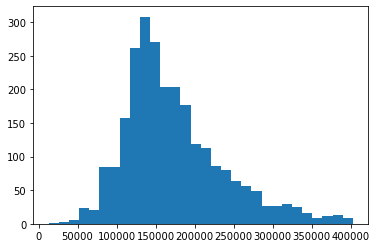

In [19]:
plt.hist(ames3['saleprice'], bins=30)

In [20]:
ames3.shape

(2535, 86)

The distribution of target variable is less skewed after removing the outliers, however a log transformation may still be desired for a more reliable model.

## Removing Abnormal Sale

By inspecting the data dictionary, there is one salecondition called 'Abnormal sale' that we want to exclude from our modeling. Abnormal Sale refers to those trade, foreclosure, and short sale. These sales may follow a different pricing pattern, which may lessen the descriptive power of our model. Therefore we want to exclude them.

In [21]:
ames3.groupby('salecondition')[['saleprice']].mean().reset_index()

,salecondition,saleprice
0,Abnorml,138218.750000
1,AdjLand,138750.000000
2,Alloca,158719.000000
3,Family,146958.823529
4,Normal,171669.506090
5,Partial,256841.319444


By looking at the average sale price of such salecondition, it is actually lower than all other type. 

In [22]:
ames3 =  ames3[ames3['salecondition'] != 'Abnorml']
ames3.shape

(2475, 86)

## Preparing data set

### Categorical Variables

Creating a list of all categorial variable for future uses.

Check the Boxplots for all categorical variable against price per sqft

In [23]:
factor_col = []
for col in ames3.columns:
    if ames3[col].dtype == 'O':
        factor_col.append(col)

AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)

C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)



AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until e

AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until e

AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)

C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until e


AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until e

AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until e

AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


C:\Users\jenny\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


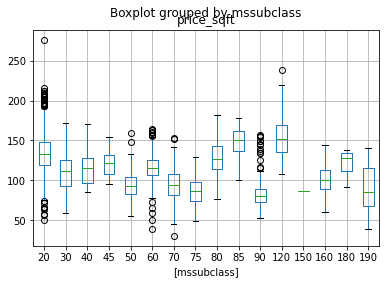

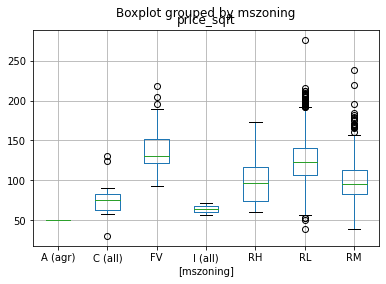

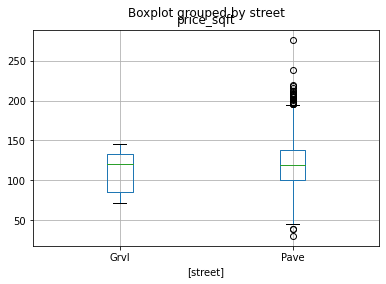

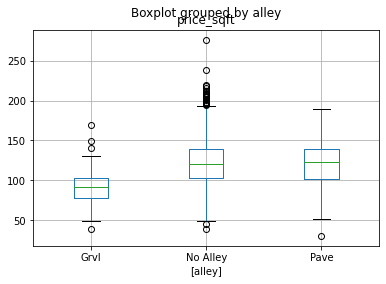

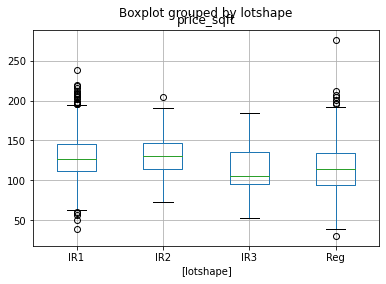

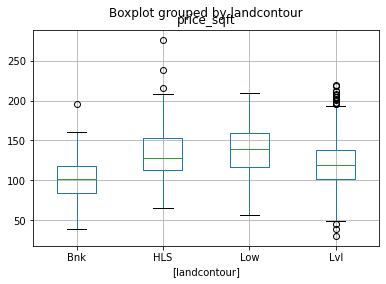

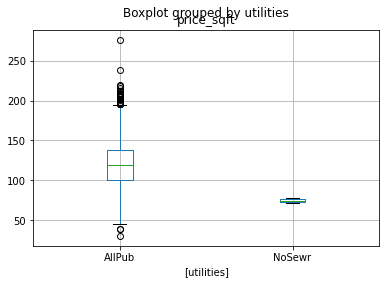

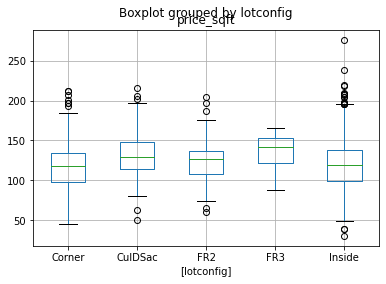

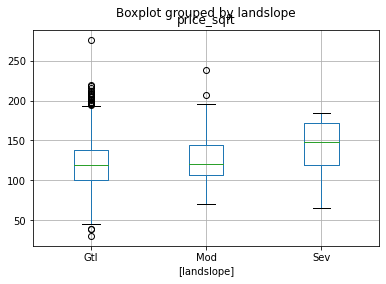

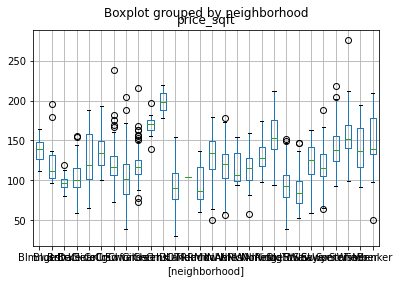

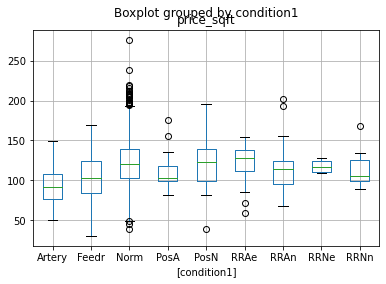

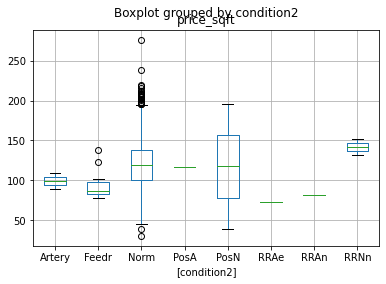

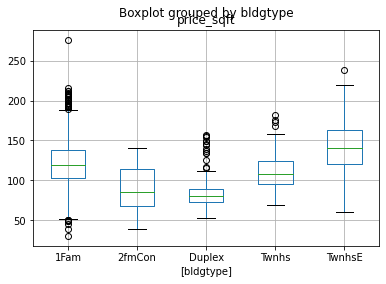

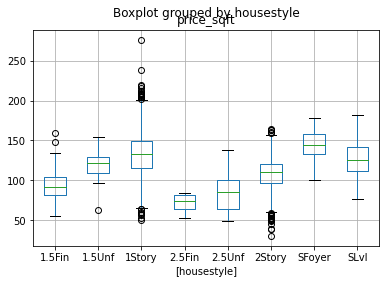

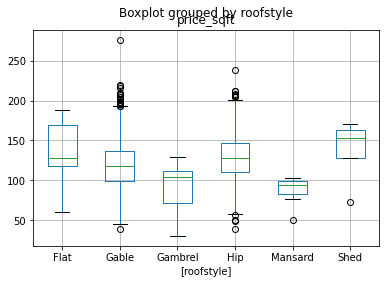

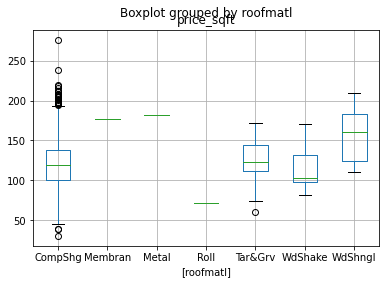

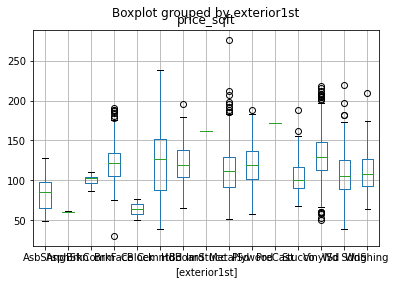

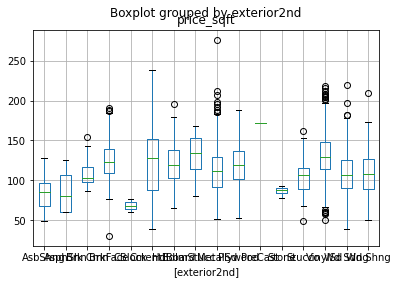

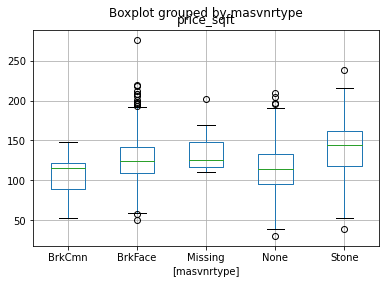

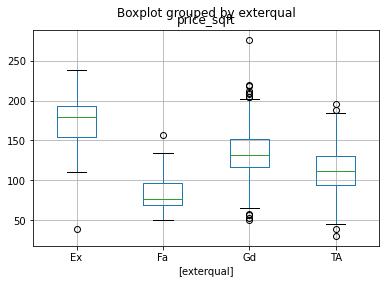

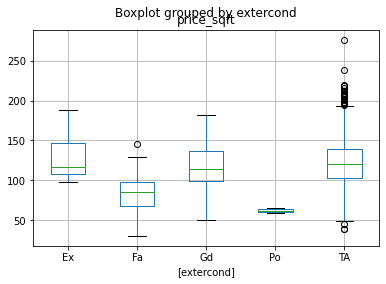

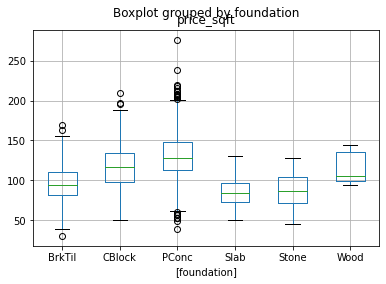

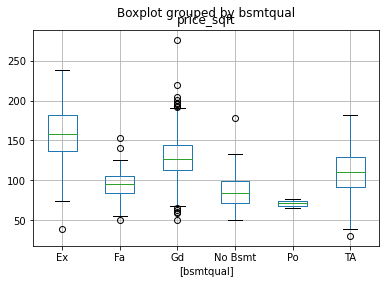

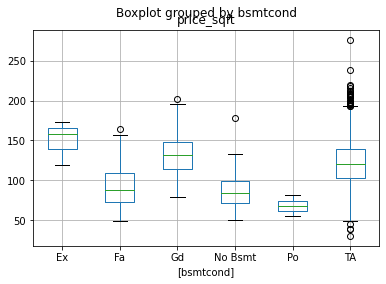

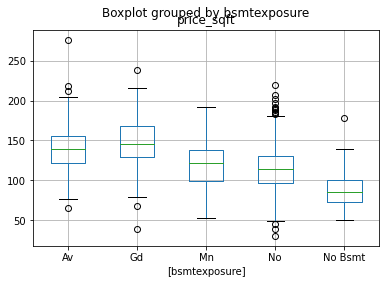

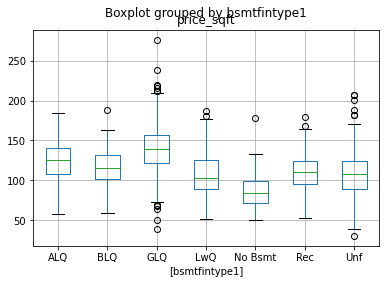

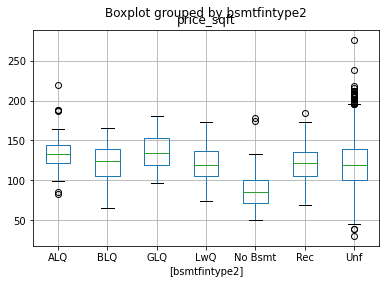

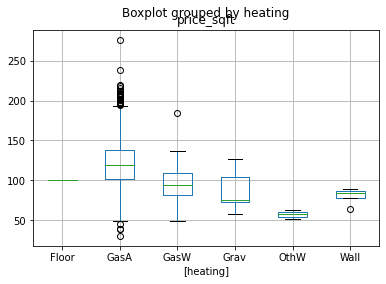

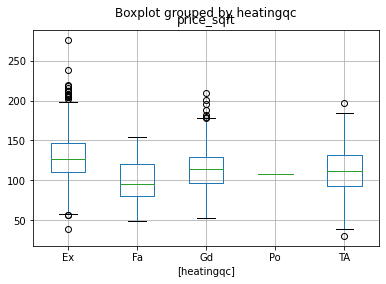

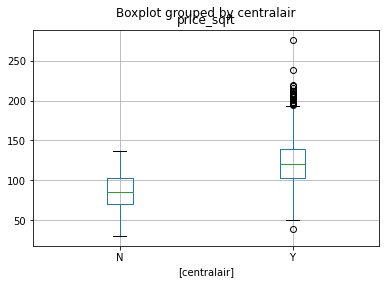

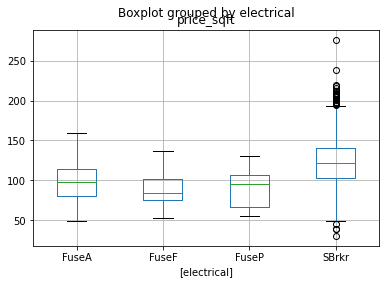

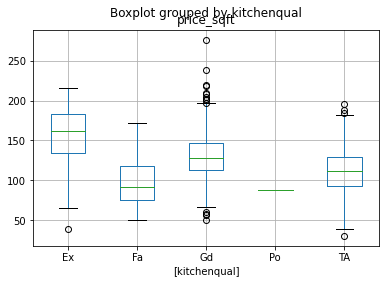

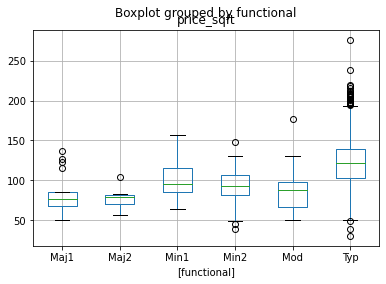

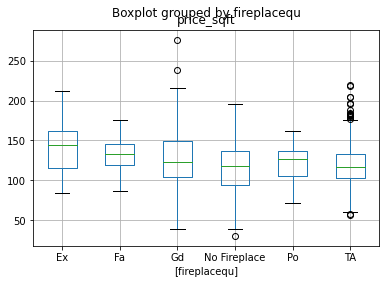

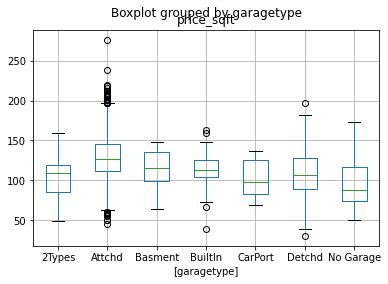

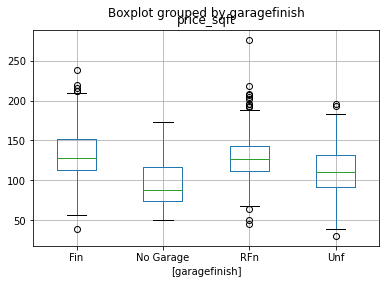

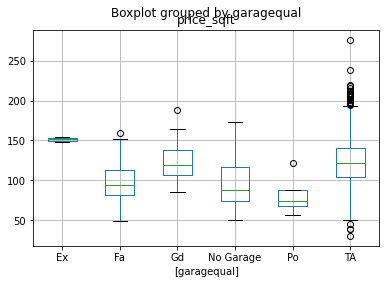

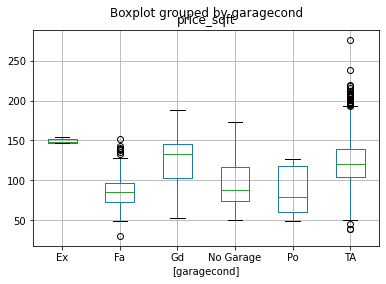

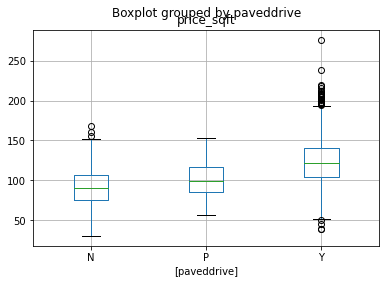

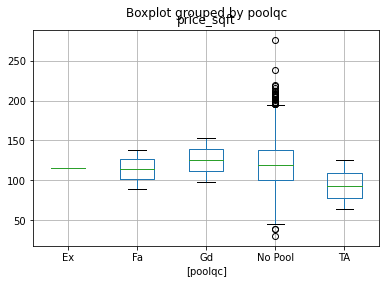

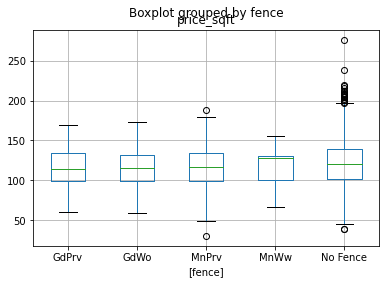

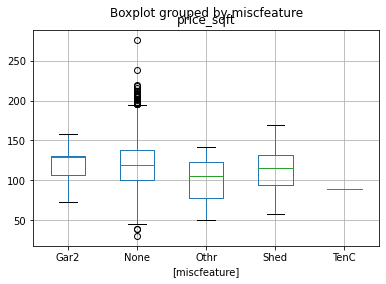

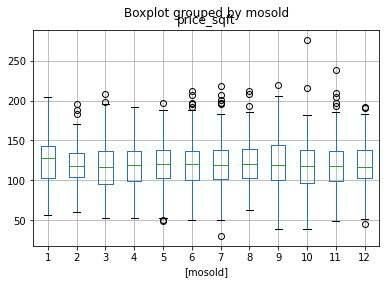

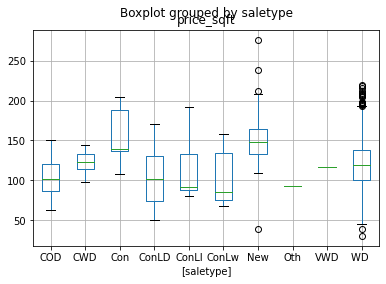

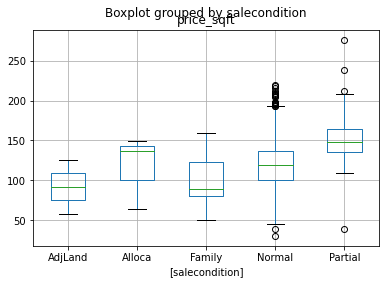

In [24]:
for col in factor_col:
    print(ames3[['price_sqft',col]].boxplot(by = col))

In [25]:
for col in factor_col:
    print(ames3[col].value_counts())

20     892
60     480
50     250
120    168
160    117
30     117
70     112
80     105
90      83
190     50
85      43
75      19
45      17
180     15
40       6
150      1
Name: mssubclass, dtype: int64
RL         1929
RM          399
FV          111
RH           20
C (all)      13
I (all)       2
A (agr)       1
Name: mszoning, dtype: int64
Pave    2465
Grvl      10
Name: street, dtype: int64
No Alley    2315
Grvl          99
Pave          61
Name: alley, dtype: int64
Reg    1578
IR1     820
IR2      64
IR3      13
Name: lotshape, dtype: int64
Lvl    2246
Bnk      92
HLS      86
Low      51
Name: landcontour, dtype: int64
AllPub    2473
NoSewr       2
Name: utilities, dtype: int64
Inside     1816
Corner      418
CulDSac     153
FR2          76
FR3          12
Name: lotconfig, dtype: int64
Gtl    2358
Mod     105
Sev      12
Name: landslope, dtype: int64
NAmes      398
CollgCr    233
OldTown    204
Edwards    160
Gilbert    142
Somerst    138
Sawyer     135
NWAmes     120
SawyerW  

By looking at the boxplots, it seems 'street', 'lotshape', 'loconfig', 'landslope', 'heatingqc', and 'fence' don't have strong influence on the price/sqft. May consider eliminating these features in the next steps.

Another observation is that many of the features have unbalanced values. This should be taken into consideration if any features are to be included in the model.

### Categorical variables

1. Convert oridinal type of features to int
2. Condense norminal categorical features to decrease the dimensions after dummification

In [26]:
ames3['heatingqc'] = ames3['heatingqc'].replace('Ex',5)
ames3['heatingqc'] = ames3['heatingqc'].replace('Gd',4)
ames3['heatingqc'] = ames3['heatingqc'].replace('TA',3)
ames3['heatingqc'] = ames3['heatingqc'].replace('Fa',2)
ames3['heatingqc'] = ames3['heatingqc'].replace('Po',1)
ames3['extercond'] = ames3['extercond'].replace('Ex',5)
ames3['extercond'] = ames3['extercond'].replace('Gd',4)
ames3['extercond'] = ames3['extercond'].replace('TA',3)
ames3['extercond'] = ames3['extercond'].replace('Fa',2)
ames3['extercond'] = ames3['extercond'].replace('Po',1)
ames3['exterqual'] = ames3['exterqual'].replace('Ex',5)
ames3['exterqual'] = ames3['exterqual'].replace('Gd',4)
ames3['exterqual'] = ames3['exterqual'].replace('TA',3)
ames3['exterqual'] = ames3['exterqual'].replace('Fa',2)
ames3['exterqual'] = ames3['exterqual'].replace('Po',1)
ames3['kitchenqual'] = ames3['kitchenqual'].replace('Ex',5)
ames3['kitchenqual'] = ames3['kitchenqual'].replace('Gd',4)
ames3['kitchenqual'] = ames3['kitchenqual'].replace('TA',3)
ames3['kitchenqual'] = ames3['kitchenqual'].replace('Fa',2)
ames3['kitchenqual'] = ames3['kitchenqual'].replace('Po',1)

In [27]:
ames3['mszoning'] = ames3['mszoning'].replace(['A (agr)','C (all)','I (all)','RH','FV'], 'others')
ames3['alley'] = ames3['alley'].replace(['Grvl','Pave'], 'others')
ames3['lotshape'] = ames3['lotshape'].replace(['IR1','IR2','IR3'], 'IR')
ames3['landcontour'] = ames3['landcontour'].replace(['HLS','Bnk','Low'], 'others')
ames3['condition1'] = ames3['condition1'].replace(['Feedr','Artery','RRAn','PosN','RRAe',\
                                                  'PosA','RRNn','RRNe'], 'others')
ames3['condition2'] = ames3['condition2'].replace(['Feedr','Artery','RRAn','PosN','RRAe',\
                                                  'PosA','RRNn','RRNe'], 'others')
ames3['housestyle'] = ames3['housestyle'].replace(['2.5Unf','1.5Unf','2.5Fin'], 'others')
ames3['roofstyle'] = ames3['roofstyle'].replace(['Hip','Gambrel','Flat','Mansard','Shed'], 'others')
ames3['roofmatl'] = ames3['roofmatl'].replace(['Tar&Grv','WdShake','WdShngl','Membran','Roll','Metal'], 'others')
ames3['salecondition'] = ames3['salecondition'].replace(['Family','Alloca','AdjLand'], 'others')
ames3['saletype'] = ames3['saletype'].replace(['ConLw','ConLI','Con','Oth','VWD','CWD','ConLD'], 'others')
ames3['mosold'] = ames3['mosold'].replace([1,2,3], 'QT1')
ames3['mosold'] = ames3['mosold'].replace([4,5,6], 'QT2')
ames3['mosold'] = ames3['mosold'].replace([7,8,9], 'QT3')
ames3['mosold'] = ames3['mosold'].replace([10,11,12], 'QT4')
ames3['miscfeature'] = ames3['miscfeature'].replace(['Shed','Gar2','Othr','TenC'], 'Yes')
ames3['garagecond'] = ames3['garagecond'].replace(['Gd','Ex'], 'Abv_Avg')
ames3['garagecond'] = ames3['garagecond'].replace(['Fa','Po'], 'Blw_Avg')
ames3['garagequal'] = ames3['garagequal'].replace(['Gd','Ex'], 'Abv_Avg')
ames3['garagequal'] = ames3['garagequal'].replace(['Fa','Po'], 'Blw_Avg')
ames3['fireplacequ'] = ames3['fireplacequ'].replace(['Gd','Ex'], 'Abv_Avg')
ames3['fireplacequ'] = ames3['fireplacequ'].replace(['Fa','Po'], 'Blw_Avg')
ames3['functional'] = ames3['functional'].replace(['Min1','Min2'], 'Min')
ames3['functional'] = ames3['functional'].replace(['Mod','Maj1','Maj2','Sev','Sal'], 'Mod_more')
ames3['electrical'] = ames3['electrical'].replace(['FuseA','FuseF','FuseP','Mix'],'Fuse')
ames3['bsmtcond'] = ames3['bsmtcond'].replace(['Gd','Ex'], 'Abv_Avg')
ames3['bsmtcond'] = ames3['bsmtcond'].replace(['Fa','Po'], 'Blw_Avg')
ames3['bsmtqual'] = ames3['bsmtqual'].replace(['Gd','Ex'], 'Abv_Avg')
ames3['bsmtqual'] = ames3['bsmtqual'].replace(['Fa','Po'], 'Blw_Avg')
ames3['exterior1st'] = ames3['exterior1st'].replace(['BrkComm','AsphShn','CBlock','PreCast','ImStucc','AsbShng'],'Others')
ames3['foundation'] = ames3['foundation'].replace(['Slab','Stone','Wood'],'Others')
ames3['heating'] = ames3['heating'].replace(['GasW','Grav','Wall','OthW','Floor'],'Others')
ames3['garagetype'] = ames3['garagetype'].replace(['Basment','2Types','CarPort'],'Others')

### Neighborhood Analysis

In [30]:
neighbor = pd.read_csv('./df_nbhd_grp1.csv')
nbgroup = neighbor[['PID','nbhd_ne','nbhd_se','nbhd_sw','nbhd_east','nbhd_west']]
merged = pd.merge(ames3,nbgroup, left_on = 'pid', right_on = 'PID', how='inner')
merged = merged[~merged.duplicated()].drop('PID',axis=1)
merged['neighborhood'] = merged[['nbhd_ne','nbhd_se','nbhd_sw','nbhd_east','nbhd_west']].idxmax(axis=1)
merged = merged.drop(['nbhd_ne','nbhd_se','nbhd_sw','nbhd_east','nbhd_west'],axis=1)

## *Data Analysis Data Set*

In [31]:
merged.head()

,pid,grlivarea,saleprice,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,price_sqft,house_age,reno_age,bbratio_abvgr,tporch
0,909176150,856,126000,30,RL,0.0,7890,Pave,No Alley,Reg,Lvl,AllPub,Corner,Gtl,nbhd_west,Norm,Norm,1Fam,1Story,6,6,1939,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,3,CBlock,TA,TA,No,Rec,238.0,Unf,0.0,618.0,856.0,GasA,3,Y,SBrkr,856,0,0,1.0,0.0,1,0,2,1,3,4,Typ,1,Abv_Avg,Detchd,1939.0,Unf,2.0,399.0,TA,TA,Y,0,0,0,0,166,0,No Pool,No Fence,None,0,QT1,2010,WD,Normal,147.196262,71,60,1.000000,166
1,905476230,1049,139500,120,RL,42.0,4235,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,nbhd_west,Norm,Norm,TwnhsE,1Story,5,5,1984,1984,Gable,CompShg,HdBoard,HdBoard,BrkFace,149.0,4,3,CBlock,Abv_Avg,TA,Mn,GLQ,552.0,ALQ,393.0,104.0,1049.0,GasA,3,Y,SBrkr,1049,0,0,1.0,0.0,2,0,2,1,4,5,Typ,0,No Fireplace,Attchd,1984.0,Fin,1.0,266.0,TA,TA,Y,0,105,0,0,0,0,No Pool,No Fence,None,0,QT1,2009,WD,Normal,132.983794,25,25,0.666667,105
3,911128020,1001,124900,30,others,60.0,6060,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,nbhd_east,Norm,Norm,1Fam,1Story,5,9,1930,2007,others,CompShg,MetalSd,MetalSd,None,0.0,4,3,BrkTil,TA,TA,No,ALQ,737.0,Unf,0.0,100.0,837.0,GasA,5,Y,SBrkr,1001,0,0,0.0,0.0,1,0,2,1,4,5,Typ,0,No Fireplace,Detchd,1930.0,Unf,1.0,216.0,TA,Blw_Avg,N,154,0,42,86,0,0,No Pool,No Fence,None,0,QT4,2007,WD,Normal,124.775225,77,0,2.000000,282
4,535377150,1039,114000,70,RL,80.0,8146,Pave,No Alley,Reg,Lvl,AllPub,Corner,Gtl,nbhd_east,Norm,Norm,1Fam,2Story,4,8,1900,2003,Gable,CompShg,MetalSd,MetalSd,None,0.0,4,4,BrkTil,Blw_Avg,TA,No,Unf,0.0,Unf,0.0,405.0,405.0,GasA,4,Y,SBrkr,717,322,0,0.0,0.0,1,0,2,1,3,6,Typ,0,No Fireplace,Detchd,1940.0,Unf,1.0,281.0,TA,TA,N,0,0,168,0,111,0,No Pool,No Fence,None,0,QT2,2009,WD,Normal,109.720885,109,6,2.000000,279
5,534177230,1665,227000,60,RL,70.0,8400,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,nbhd_east,Norm,Norm,1Fam,2Story,8,6,2001,2001,Gable,CompShg,VinylSd,VinylSd,None,0.0,4,3,PConc,Abv_Avg,TA,No,GLQ,643.0,Unf,0.0,167.0,810.0,GasA,5,Y,SBrkr,810,855,0,1.0,0.0,2,1,3,1,4,6,Typ,0,No Fireplace,Attchd,2001.0,Fin,2.0,528.0,TA,TA,Y,0,45,0,0,0,0,No Pool,No Fence,None,0,QT4,2009,WD,Normal,136.336336,8,8,0.857143,45


# Standardize Numeric Variables

Standardize all the numeric variables for better comparebility for the beta coefiicients.
The target variable 'saleprice' will be taking log transformation.
For Random Forest, we are not dummifying the categorical variables. 

In [48]:
merged2 = merged.copy()

from sklearn.preprocessing import LabelEncoder
cols = merged2.select_dtypes(include=['object']).columns
# Process columns and apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(merged2[c].values)) 
    merged2[c] = lbl.transform(list(merged2[c].values))

for col in merged2.columns:
    if col == 'pid':
        continue
        
    elif col == 'saleprice':
        merged2['saleprice'] = np.log10(merged2['saleprice'])
        
    elif col == 'mssubclass':
        continue
        
    elif merged2[col].dtype != 'O':         
        merged2[col] = (merged2[col] - merged2[col].mean()) / merged2[col].std()

merged2.head()

,pid,grlivarea,saleprice,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,price_sqft,house_age,reno_age,bbratio_abvgr,tporch
0,909176150,-1.321797,5.100371,1,-0.490345,-1.670999,-0.257147,0.060646,-0.263102,0.754626,-0.318354,-0.020182,-1.933586,-0.212217,1.330466,-0.392613,-0.09061,-0.427866,-0.455277,-0.013472,0.331021,-1.059906,-1.648563,-0.490334,-0.111203,1.147087,1.062795,0.567903,-0.565983,-0.663647,-0.251528,-0.689844,1.061155,0.313648,0.561074,0.848292,-0.468331,0.363903,-0.306176,0.183398,-0.424220,-0.127027,-1.187998,0.255048,0.299369,-0.773712,-0.799040,-0.095055,1.115682,-0.254234,-1.006807,-0.753530,-1.046989,-0.198767,-0.741857,-1.567721,0.262303,0.631364,-1.571709,1.045916,0.136436,0.913118,0.363424,-0.313564,0.309789,0.278283,0.313827,-0.740003,-0.703450,-0.357959,-0.101803,2.700869,-0.054509,0.025821,0.474997,-0.201689,-0.099465,-1.518532,1.644763,0.115611,-0.188301,0.928655,1.132731,1.758026,-0.710375,-0.092937
1,905476230,-0.905927,5.144574,11,-0.490345,-0.407836,-0.706108,0.060646,-0.263102,0.754626,-0.318354,-0.020182,0.583357,-0.212217,1.330466,-0.392613,-0.09061,2.816644,-0.455277,-0.782611,-0.566943,0.466115,0.016014,-0.490334,-0.111203,-1.216404,-1.176348,-1.390245,0.353362,1.196231,-0.251528,-0.689844,-0.991210,0.313648,-0.327595,-0.495582,0.299072,-4.205828,1.963330,-1.025400,0.067036,-0.127027,-1.187998,0.255048,0.299369,-0.228849,-0.799040,-0.095055,1.115682,-0.254234,0.843276,-0.753530,-1.046989,-0.198767,0.867029,-0.900923,0.262303,-0.931135,0.287831,-0.758528,0.242243,-1.609431,-1.015564,-0.973524,0.309789,0.278283,0.313827,-0.740003,0.920310,-0.357959,-0.101803,-0.279143,-0.054509,0.025821,0.474997,-0.201689,-0.099465,-1.518532,0.881023,0.115611,-0.188301,0.437003,-0.426918,0.040517,-1.217411,-0.480952
3,911128020,-1.009355,5.096562,1,3.071183,0.133520,-0.481935,0.060646,-0.263102,0.754626,-0.318354,-0.020182,0.583357,-0.212217,-0.911328,-0.392613,-0.09061,-0.427866,-0.455277,-0.782611,3.024913,-1.365111,1.142051,2.038595,-0.111203,-0.822489,-0.616562,0.567903,-0.565983,1.196231,-0.251528,-1.587336,1.061155,0.313648,0.561074,-1.391498,0.751204,0.363903,-0.306176,-1.034807,-0.472582,-0.127027,0.906462,0.255048,0.299369,-0.364359,-0.799040,-0.095055,-0.829630,-0.254234,-1.006807,-0.753530,-1.046989,-0.198767,0.867029,-0.900923,0.262303,-0.931135,0.287831,1.045916,0.115274,0.913118,-1.015564,-1.221629,0.309789,-4.087116,-3.462867,0.471896,-0.703450,0.298589,3.215634,-0.279143,-0.054509,0.025821,0.474997,-0.201689,-0.099465,1.772812,-0.646457,0.115611,-0.188301,0.153043,1.336163,-1.186276,0.810730,0.644929
4,535377150,-0.927474,5.056905,6,-0.490345,0.735026,-0.225702,0.060646,-0.263102,0.754626,-0.318354,-0.020182,-1.933586,-0.212217,-0.911328,-0.392613,-0.09061,-0.427866,0.540008,-1.551750,2.126949,-2.382459,0.946218,-0.490334,-0.111203,-0.822489,-0.616562,0.567903,-0.565983,1.196231,2.433256,-1.587336,-0.307089,0.313648,0.561074,1.296250,-1.049993,0.363903,-0.306176,-0.317524,-1.572180,-0.127027,-0.140768,0.255048,0.299369,-1.166126,-0.031432,-0.095055,-0.829630,-0.254234,-1.006807,-0.753530,-1.046989,-0.198767,-0.741857,-0.234126,0.262303,-0.931135,0.287831,1.045916,0.138787,0.913118,-1.015564,-0.899093,0.309789,0.278283,-3.46

Target feature is less skewed after log transformation.

In [49]:
merged2.columns.tolist()

['pid',
 'grlivarea',
 'saleprice',
 'mssubclass',
 'mszoning',
 'lotfrontage',
 'lotarea',
 'street',
 'alley',
 'lotshape',
 'landcontour',
 'utilities',
 'lotconfig',
 'landslope',
 'neighborhood',
 'condition1',
 'condition2',
 'bldgtype',
 'housestyle',
 'overallqual',
 'overallcond',
 'yearbuilt',
 'yearremodadd',
 'roofstyle',
 'roofmatl',
 'exterior1st',
 'exterior2nd',
 'masvnrtype',
 'masvnrarea',
 'exterqual',
 'extercond',
 'foundation',
 'bsmtqual',
 'bsmtcond',
 'bsmtexposure',
 'bsmtfintype1',
 'bsmtfinsf1',
 'bsmtfintype2',
 'bsmtfinsf2',
 'bsmtunfsf',
 'totalbsmtsf',
 'heating',
 'heatingqc',
 'centralair',
 'electrical',
 '1stflrsf',
 '2ndflrsf',
 'lowqualfinsf',
 'bsmtfullbath',
 'bsmthalfbath',
 'fullbath',
 'halfbath',
 'bedroomabvgr',
 'kitchenabvgr',
 'kitchenqual',
 'totrmsabvgrd',
 'functional',
 'fireplaces',
 'fireplacequ',
 'garagetype',
 'garageyrblt',
 'garagefinish',
 'garagecars',
 'garagearea',
 'garagequal',
 'garagecond',
 'paveddrive',
 'wooddecksf',

### *****Lasso Test-Train set split

In [50]:
target = merged2['saleprice']
features = ['pid',
 'grlivarea',
 'mssubclass',
 'mszoning',
 'lotfrontage',
 'lotarea',
 'street',
 'alley',
 'lotshape',
 'landcontour',
 'utilities',
 'lotconfig',
 'landslope',
 'neighborhood',
 'condition1',
 'condition2',
 'bldgtype',
 'housestyle',
 'overallqual',
 'overallcond',
 'yearbuilt',
 'yearremodadd',
 'roofstyle',
 'roofmatl',
 'exterior1st',
 'exterior2nd',
 'masvnrtype',
 'masvnrarea',
 'exterqual',
 'extercond',
 'foundation',
 'bsmtqual',
 'bsmtcond',
 'bsmtexposure',
 'bsmtfintype1',
 'bsmtfinsf1',
 'bsmtfintype2',
 'bsmtfinsf2',
 'bsmtunfsf',
 'totalbsmtsf',
 'heating',
 'heatingqc',
 'centralair',
 'electrical',
 '1stflrsf',
 '2ndflrsf',
 'lowqualfinsf',
 'bsmtfullbath',
 'bsmthalfbath',
 'fullbath',
 'halfbath',
 'bedroomabvgr',
 'kitchenabvgr',
 'kitchenqual',
 'totrmsabvgrd',
 'functional',
 'fireplaces',
 'fireplacequ',
 'garagetype',
 'garageyrblt',
 'garagefinish',
 'garagecars',
 'garagearea',
 'garagequal',
 'garagecond',
 'paveddrive',
 'wooddecksf',
 'openporchsf',
 'enclosedporch',
 '3ssnporch',
 'screenporch',
 'poolarea',
 'poolqc',
 'fence',
 'miscfeature',
 'miscval',
 'mosold',
 'yrsold',
 'saletype',
 'salecondition',
 'house_age',
 'reno_age',
 'bbratio_abvgr',
 'tporch']

In [51]:
X_feature = merged2[features]

In [52]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_feature, target, test_size=0.33, random_state=0)

# from sklearn.linear_model import Lasso
# lasso = Lasso()

# coefs = []
# intercepts = []
# R2_train  = []
# R2_test  = []
# coefs_dict = {}

# alphaRange = np.logspace(-4,-1,20)
# for alpha in alphaRange:
#           lasso.set_params(alpha=alpha)  
#           lasso.fit(X_train, y_train)
#           intercepts.append(lasso.intercept_)
#           coefs.append(lasso.coef_)
#           coefs_dict[alpha] = lasso.coef_
#           R2_train.append(lasso.score(X_train, y_train)) 
#           R2_test.append(lasso.score(X_test, y_test))

In [53]:
from sklearn import ensemble
randomForest = ensemble.RandomForestRegressor()

# fit RF model on training set
randomForest.set_params(random_state=0)

randomForest.fit(X_train, y_train) 

print("The training error is: %.5f" % (1 - randomForest.score(X_train, y_train)))
print("The test     error is: %.5f" % (1 - randomForest.score(X_test, y_test)))

The training error is: 0.01557
The test     error is: 0.10565


In [95]:
# set the parameter grid
grid_para_forest = {
    'criterion': ['mse'],
    'max_depth': range(5, 26, 5),
    'n_estimators': [300, 600],
    'max_features': [10, 20, 83]
}

In [96]:
# run the RF classifier through the grid search
from sklearn.model_selection import GridSearchCV
grid_search_forest = GridSearchCV(randomForest, grid_para_forest, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
%time grid_search_forest.fit(X_train, y_train)

Wall time: 2min 7s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['mse'], 'max_depth': range(5, 26, 5),
                         'max_features': [10, 20, 83],
                         'n_estimators': [300, 600]},
             scoring='neg_mean_squared_error')

In [97]:
# get the best parameters
grid_search_forest.best_params_

{'criterion': 'mse', 'max_depth': 25, 'max_features': 20, 'n_estimators': 600}

In [98]:
# get the best score
grid_search_forest.best_score_

-0.0025767054133513808

In [99]:
# get the training/test errors
print("The training R2 is: %.5f" % (grid_search_forest.best_estimator_.score(X_train, y_train)))
print("The test R2 is: %.5f" % (grid_search_forest.best_estimator_.score(X_test, y_test)))

The training R2 is: 0.98623
The test R2 is: 0.90749


In [100]:
np.mean((grid_search_forest.best_estimator_.predict(X_test)-y_test)**2)**.5

0.04752368126566343

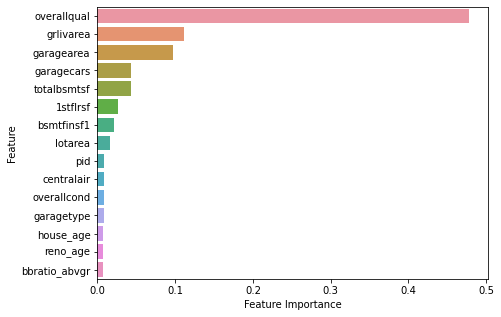

In [106]:
feature_importance = randomForest.feature_importances_
rf_feature_importances = pd.Series(feature_importance, index=X_train.columns.values).sort_values(ascending=False).head(15)

fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(x=rf_feature_importances,y=rf_feature_importances.index,);
plt.xlabel('Feature Importance');
plt.ylabel('Feature');
